# Packages:

In [1]:
import torch
import scipy
import copy
import scipy.linalg
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


from utils import calculate_Atilde, cSBM, mean_agg, MLP, LR

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Node Class:

In [3]:
class Node:
    
    
    def __init__(self, local_model, node_idx, X, y):
        
        """
        local model: The local MLP model for each node
        node_idx: The unique index of a node
        X: [n_k, p], feature matrix, float tensor
        y: [n_k], true labels, long tensor
        """
        
        self.model = local_model
        self.idx = node_idx
        self.X = X.type(torch.FloatTensor).to(device)
        self.y = y.to(device)
        self.n_k = X.shape[0]
        self.dataloader = None
        self.optimizer = None
        
        
    def upload_local_parameters(self):
        
        """
        Upload local model parameters to central server.
        Usually used for aggregation step in each communication.
        """
        
        return self.model.state_dict()
    
    
    def receieve_central_parameters(self, central_parameters):
        
        """
        central_parameters: A state dictonary for central server parameters.
        
        Receive the broadcasted central parameters.
        """
        
        with torch.no_grad():
            for pname, param in self.model.named_parameters():
                param.copy_(central_parameters[pname])
                
                
    def upload_h(self, gradient=True):
        
        
        """
        This function uploads an random hidden vector from a node to the central server.
        It also calculate and upload a dictonary of gradients  (dh/dw, 3D tensors) for each parameter w.r.t the local model
        """ 
        
        x = self.X[np.random.choice(a=self.n_k),:]
        
        if gradient:
            
            # Clear the possible accumulated gradient of the parameters of local model
            self.model.zero_grad()
        
            h = self.model(x).view(1, -1)
            
            num_class = h.shape[-1]

            dh = {}

            for i in range(num_class):

                h[0, i].backward(retain_graph=True)

                for pname, param in self.model.named_parameters():

                    if pname in dh:
                        dh[pname].append(param.grad.data.clone())
                    else:
                        dh[pname] = []
                        dh[pname].append(param.grad.data.clone())

                    if (i == num_class-1):
                        d1, d2 = dh[pname][0].shape
                        dh[pname] = torch.cat(dh[pname], dim=0).view(num_class, d1, d2)

                self.model.zero_grad()

            return h, dh
        
        else:
            with torch.no_grad():
                h = self.model(x).view(1, -1)
                
        return h
    
    
    def upload_data(self, m=1):
        
        # Upload the m number of local data for evaluation purpose.
        
        if (m > self.n_k):
            raise ValueError("m is bigger than n_k!")
            
        ids = np.random.choice(a=self.n_k, size=m, replace=False)
        
        X = self.X[ids,:].view(m, 1, -1)
        
        y = self.y[ids].view(m, 1)
        
        return X, y
    
    def local_update(self, A_tilde_k, C_k, dH, I, 
                     opt="Adam",
                     learning_rate=0.01, num_epochs=10, 
                     gradient=True, gradient_clipping=None):
        
        """
        The local update process for a node k.
        
        A_tilde_k: The kth row of PageRank matrix A_tilde.
        
        C_k: [1, num_class] The aggregated neighborhood information for node k.
        
        dH: A list of gradient dictonaries, where the kth dictonary contains the gradients of each parameter for node k.
        
        I: Number of local updates.
        
        opt: Optimizer used for local updates: SGD or Adam. Default: "Adam"
        
        learning rate: learning rate for SGD. Default: 0.1
        
        gradient: boolean, whether to include the "fake gradient" or not. Default: True
        
        gradient_clipping: Whether to peform gradient clipping method during training process. None means no gradient clipping,
        if a number (int or float) is given, then the maximum norm is determined by this number. Default: None.
        """
        
        if (self.dataloader == None):
            batch_size = int(np.floor(self.n_k/I))
            dataset = torch.utils.data.TensorDataset(self.X, self.y)
            self.dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
            
        k = self.idx
        
        N = A_tilde_k.shape[0]
        
        num_class = C_k.shape[-1]
        
        if (opt == "Adam"):
            optimizer = optim.Adam(self.model.parameters())
            
        else:
            optimizer = optim.SGD(self.model.parameters(), lr=learning_rate)
            
        for epoch in range(num_epochs):

            for X_B, y_B in self.dataloader:
                
                #X_B, y_B = X_B.to(device), y_B.to(device)

                optimizer.zero_grad()
                
                B = X_B.shape[0]
            
                H_B = self.model(X_B)
                Z_B = A_tilde_k[k]*H_B + C_k
                y_B_hat = F.softmax(Z_B, dim=1)
                
                if (gradient == True and dH != None):
                    
                    batch_loss = F.nll_loss(torch.log(y_B_hat), y_B, reduction="sum")
                    batch_loss.backward()
                    
                    with torch.no_grad():
                        y_B_onehot = torch.zeros(B, num_class).to(device)
                        y_B_onehot[np.arange(B), y_B] = 1
                        Errs = y_B_hat - y_B_onehot
                        for pname, param in self.model.named_parameters():
                            for i in range(N):
                                if (i != k):
                                    param.grad.data += A_tilde_k[i]*torch.tensordot(Errs, dH[i][pname], dims=1).sum(dim=0)
                            param.grad.data = param.grad.data/B
                            
                else:
                    batch_loss = F.nll_loss(torch.log(y_B_hat), y_B, reduction="mean")
                    batch_loss.backward()
                    
                    
                # Gradient Clipping
                            
                if (gradient_clipping == None):     
                    optimizer.step()
                    
                elif (type(gradient_clipping) == float or type(gradient_clipping) == int):
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), gradient_clipping, norm_type=2)
                    optimizer.step()
                    
                else:
                    raise ValueError("Unkown type of gradient clipping value!")

# Central Server Class:

In [4]:
class Central_Server:
    
    def __init__(self, node_list, A_tilde):
        
        """
        A_tilde: PageRank matrix
        node_list: A list contains objects from Node class
        """
        
        self.A_tilde = A_tilde.to(device)
        self.node_list = node_list
        self.N = len(node_list)
        self.central_parameters = None
        self.cmodel = None
        
    def init_central_parameters(self, input_dim, hidden_dim, output_dim, nn_type):
        
        """
        Initialize the central server parameter dictonary
        """
        
        if (nn_type == "MLP"):
            self.cmodel = MLP(input_dim, hidden_dim, output_dim)
            
        elif (nn_type == "LR"):
            self.cmodel = LR(input_dim, output_dim)
            
        
        self.central_parameters = copy.deepcopy(self.cmodel.state_dict())
        
        
    def broadcast_central_parameters(self):
        
        """
        Broadcast the current central parameters to all nodes.
        Usually used after the aggregation in the end of each communication
        """
        
        if self.central_parameters == None:
            raise ValueError("Central parameters is None, Please initilalize it first.")
        
        for node in self.node_list:
            node.receieve_central_parameters(self.central_parameters)
        
    def collect_hs(self, gradient=True):
        
        """
        Collect h and dh from each node.
        """
        
        H = []
        
        if gradient:
            
            dH = []

            for i in range(self.N):
                h_i, dh_i = self.node_list[i].upload_h(gradient)
                H.append(h_i)
                dH.append(dh_i)

            # H: [N, num_class]
            H = torch.cat(H, dim=0)

            # dH: a list of gradient dictonaries
            return H, dH
        
        else:
            for i in range(self.N):
                h_i = self.node_list[i].upload_h(gradient)
                H.append(h_i)

            # H: [N, num_class]
            H = torch.cat(H, dim=0)
            
            return H, None
        
            
    def collect_data(self, m):
        
        Xs = []
        
        ys = []
        
        for node in self.node_list:
            
            X, y = node.upload_data(m)
            
            Xs.append(X)
            ys.append(y)
            
            
        # Xs; [m, N, p]
        # ys: [m, N]
            
        Xs = torch.cat(Xs, dim=1)
        
        ys = torch.cat(ys, dim=1)
        
        return Xs, ys
            
            
        
    def communication(self, train_indices, test_indices, I, 
                      aggregation=mean_agg, 
                      opt="Adam", learning_rate=0.1, 
                      num_epochs=10, gradient=True, m=10, 
                      gradient_clipping=None):
        
        """
        train_indices: A list of indices for the nodes that will be used during training.
        
        I: Number of local updates.
        
        test_indices: A list of indices for the nodes that will be used for testing purpose.
        
        num_epochs: Number of training epochs for each training node during local update.
        
        aggregation: aggregation method, for now, only mean aggregation is implemented. Default: mean_agg. 
        
        learning_rate: Learning rate for SGD. Default: 0.1
    
        opt: optimization method: Adam or SGD. Default: "Adam"

        gradient: boolean, whether to include the "fake gradient" or not. Default: True

        m: The number of feature vectors used for training loss evaluation in the end of each communication for each node. 
           Default: 10
           
        gradient_clipping: Whether to peform gradient clipping method during training process. None means no gradient clipping,
                           if a number (int or float) is given, then the maximum norm is determined by this number. 
                           Default: None.
        """
        
        self.broadcast_central_parameters()
        
        # H: [N, num_class]
        H, dH = self.collect_hs(gradient)
        
        # C: [N, num_class]
        with torch.no_grad():
            C = torch.matmul(self.A_tilde, H)
        
        for k in train_indices:
            with torch.no_grad():
                C_k = C[k,:] - self.A_tilde[k,k]*H[k,:]
    
            self.node_list[k].local_update(self.A_tilde[k,:], C_k, dH, 
                                           I, opt, learning_rate, num_epochs, gradient, gradient_clipping)
            
        aggregation(self.central_parameters, self.cmodel, self.node_list, train_indices)
        
        
        # Xs: [m, N, p]
        # ys: [m, N]
        Xs, ys = self.collect_data(m)
        
        with torch.no_grad():
            
            # Hs: [m, N, num_class]
            Hs = self.cmodel(Xs)
            
            # Zs: [m, N, num_class]
            Zs = torch.matmul(self.A_tilde, Hs)
            
            
            # train_Zs: [m, num_train, num_class]
            # train_ys: [m, num_train]
            train_Zs = Zs[:,train_indices,:]
            train_ys = ys[:,train_indices]
            
            num_train = len(train_indices)
            
            train_loss = F.cross_entropy(train_Zs.view(m*num_train, -1), train_ys.view(m*num_train)).item()
        
        return train_loss    

# cSBM Training

In [21]:
def train_CSBM(csbm, A_tilde, hidden_dim, num_train, I, 
               num_communication=20, aggregation=mean_agg,
               learning_rate=0.1, opt="Adam", num_epochs=10,
               gradient=True, m=10, gradient_clipping=None,
               nn_type="MLP", output_dim=2):
    
    """
    csbm: An cSBM object (contextual stochastic block model)
    
    A_tilde: pageRank matrix
    
    I: number of local updates for each node, so batch size = n_k/I for each node k.
    
    num_train: Number of nodes used in training.
    
    aggregation: aggregation method, for now, only mean aggregation is implemented. Default: mean_agg. 
    
    num_communication: Number of communicatons. Default: 20
    
    learning_rate: Learning rate for SGD. Default: 0.1
    
    opt: optimization method: Adam or SGD. Default: "Adam"
    
    gradient: boolean, whether to include the "fake gradient" or not. Default: True
    
    m: The number of feature vectors used for training loss evaluation in the end of each communication for each node. 
       Default: 10
       
    gradient_clipping: Whether to peform gradient clipping method during training process. None means no gradient clipping,
                       if a number (int or float) is given, 
                       then the maximum norm is determined by this number. Default: None.
                       
    nn_type: The type of neural network. either "MLP" or "LR" (i.e. MLP or Logistic Regression). Default:"MLP".
    """
    
    N = A_tilde.shape[0]
    
    input_dim = csbm.p
    
    node_list = []
    
    for i in range(N):
        
        X = []
        
        if (nn_type == "MLP"):
            model_i = MLP(input_dim, hidden_dim, output_dim).to(device)
            
        elif (nn_type == "LR"):
            model_i = LR(input_dim, output_dim).to(device)
            
        else:
            raise ValueError("Type of neural network must be either LR or MLP!")
        
        node_i = Node(local_model=model_i, node_idx=i, X=csbm.Xs[i], y=csbm.ys[i])
        
        node_list.append(node_i)
        
    server = Central_Server(node_list, A_tilde)
    
    server.init_central_parameters(input_dim, hidden_dim, output_dim, nn_type)
    
    server.cmodel = server.cmodel.to(device)
    
    if (num_train == N):
        
        train_indices = np.arange(N)
        
        test_indices = []
        
        np.random.shuffle(train_indices)
    
    else:
        
        class1_train = np.random.choice(a=csbm.class1_ids, size=int(num_train/2), replace=False)

        class2_train = np.random.choice(a=csbm.class2_ids, size=int(num_train/2), replace=False)

        train_indices = np.concatenate((class1_train, class2_train), axis=0)

        test_indices = list(set(np.arange(N)) - set(train_indices))
    
    train_loss = []
    
    for ith in range(num_communication):
        
        average_train_loss = server.communication(train_indices, test_indices, 
                                                  I, aggregation, opt, learning_rate, num_epochs,
                                                  gradient, m, gradient_clipping)
        train_loss.append(average_train_loss)
        
        if (num_communication <= 30):
                print ("Communication:", ith+1, "Average train loss:", average_train_loss)

        elif (num_communication > 30 and num_communication <= 100):
            if (ith % 5 == 0):
                print ("Communication:", ith+1, "Average train loss:", average_train_loss)

        elif (num_communication >= 5000 and num_communication < 10000):
            if (ith % 100 == 0):
                print ("Communication:", ith+1, "Average train loss:", average_train_loss)

        else:
            if (ith % 1000 == 0):
                print ("Communication:", ith+1, "Average train loss:", average_train_loss)

    return train_loss

In [28]:
N = 100
p = 10
d = 5
mu = 1
l = 2
csbm = cSBM(N, p, d, mu, l)
A_tilde = calculate_Atilde(csbm.A, 100, 0.95)

csbm.generate_features(1)

csbm.v.sum()

0

In [29]:
tl = train_CSBM(csbm=csbm, A_tilde=A_tilde, hidden_dim=200,
           I=1, num_communication=5000, aggregation=mean_agg, num_train=100, num_epochs=1,
           gradient=True, m=1, gradient_clipping=None, nn_type="LR")

Communication: 1 Average train loss: 0.6854392290115356
Communication: 101 Average train loss: 0.6812695860862732
Communication: 201 Average train loss: 0.6771379709243774
Communication: 301 Average train loss: 0.6730444431304932
Communication: 401 Average train loss: 0.6689886450767517
Communication: 501 Average train loss: 0.6649706363677979
Communication: 601 Average train loss: 0.6609905958175659
Communication: 701 Average train loss: 0.6570484042167664
Communication: 801 Average train loss: 0.6531438231468201
Communication: 901 Average train loss: 0.6492763757705688
Communication: 1001 Average train loss: 0.6454465389251709
Communication: 1101 Average train loss: 0.641654372215271
Communication: 1201 Average train loss: 0.6378995776176453
Communication: 1301 Average train loss: 0.6341819167137146
Communication: 1401 Average train loss: 0.6305015683174133
Communication: 1501 Average train loss: 0.6268583536148071
Communication: 1601 Average train loss: 0.6232523918151855
Communicat

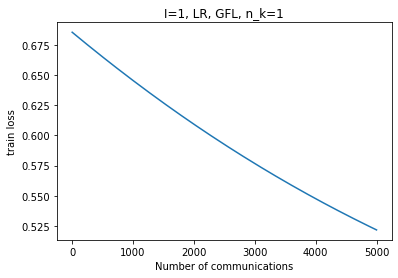

In [30]:
plt.plot(tl)
plt.xlabel("Number of communications")
plt.ylabel("train loss")
plt.title("I=1, LR, GFL, n_k=1")
plt.savefig("I=1, LR, GFL, n_k=1")

Communication: 1 Average train loss: 0.7012357115745544
Communication: 11 Average train loss: 0.697219967842102
Communication: 21 Average train loss: 0.6933539509773254
Communication: 31 Average train loss: 0.6894695162773132
Communication: 41 Average train loss: 0.685464084148407
Communication: 51 Average train loss: 0.6813015341758728
Communication: 61 Average train loss: 0.6779285669326782
Communication: 71 Average train loss: 0.6735149621963501
Communication: 81 Average train loss: 0.6691377758979797
Communication: 91 Average train loss: 0.6662576794624329
Communication: 101 Average train loss: 0.663036584854126
Communication: 111 Average train loss: 0.6596061587333679
Communication: 121 Average train loss: 0.655593752861023
Communication: 131 Average train loss: 0.6519208550453186
Communication: 141 Average train loss: 0.6488722562789917
Communication: 151 Average train loss: 0.646115243434906
Communication: 161 Average train loss: 0.642170250415802
Communication: 171 Average trai

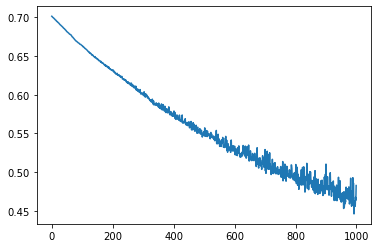

In [9]:
N = 100
p = 10
d = 5
mu = 1
l = 2
csbm = cSBM(N, p, d, mu, l)
A_tilde = calculate_Atilde(csbm.A, 100, 0.95)

csbm.generate_features(10)


tl1 = train_CSBM(csbm=csbm, A_tilde=A_tilde, hidden_dim=200,
           I=1, num_communication=1000, aggregation=mean_agg, num_train=100, num_epochs=10,
           gradient=True, m=10, gradient_clipping=None, nn_type="LR")

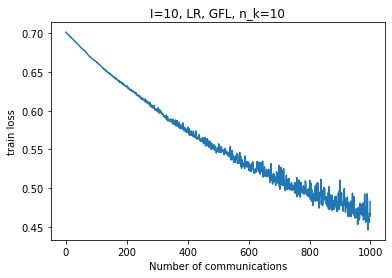

In [18]:
plt.plot(tl1)
plt.xlabel("Number of communications")
plt.ylabel("train loss")
plt.title("I=10, LR, GFL, n_k=10")
plt.savefig("I=10, LR, GFL, n_k=10")

Communication: 1 Average train loss: 0.690018892288208
Communication: 11 Average train loss: 0.6879150867462158
Communication: 21 Average train loss: 0.6858468055725098
Communication: 31 Average train loss: 0.6843849420547485
Communication: 41 Average train loss: 0.6828007102012634
Communication: 51 Average train loss: 0.680586040019989
Communication: 61 Average train loss: 0.6788432002067566
Communication: 71 Average train loss: 0.6768629550933838
Communication: 81 Average train loss: 0.6749058365821838
Communication: 91 Average train loss: 0.6726202964782715
Communication: 101 Average train loss: 0.6711740493774414
Communication: 111 Average train loss: 0.6688145995140076
Communication: 121 Average train loss: 0.6669912338256836
Communication: 131 Average train loss: 0.6650493144989014
Communication: 141 Average train loss: 0.6631566882133484
Communication: 151 Average train loss: 0.6612930297851562
Communication: 161 Average train loss: 0.6602697968482971
Communication: 171 Average 

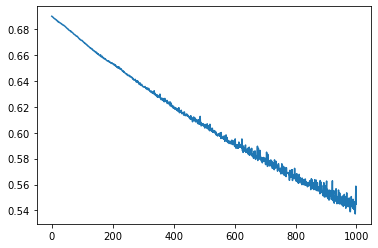

In [10]:
tl2 = train_CSBM(csbm=csbm, A_tilde=A_tilde, hidden_dim=200,
           I=1, num_communication=1000, aggregation=mean_agg, num_train=100, num_epochs=5,
           gradient=True, m=10, gradient_clipping=None, nn_type="LR")

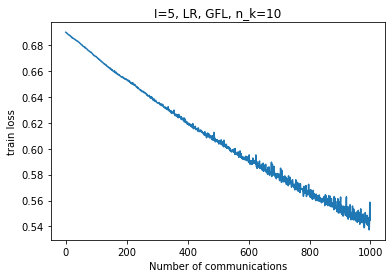

In [17]:
plt.plot(tl2)
plt.xlabel("Number of communications")
plt.ylabel("train loss")
plt.title("I=5, LR, GFL, n_k=10")
plt.savefig("I=5, LR, GFL, n_k=10")